# Paper Implementation : Learning Gradients of Convex functions with Monotone Gradient Networks

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn

plt.rcParams.update({
    "text.usetex": True,           
    "font.family": "serif", 
    "font.serif": ["Computer Modern Roman"],
})

# 1- Gradient Field

Implementation of C-MGN and ICGN

In [2]:
# C-MGN
class C_MGN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation='sigmoid'):
        super(C_MGN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        # the matrix params is shared across layers
        self.W = nn.Parameter(torch.randn(input_dim, hidden_dim))
        
        # biases b0 to bL
        self.biases = nn.ParameterList([nn.Parameter(torch.randn(hidden_dim)) for _ in range(num_layers)])
        self.bL = nn.Parameter(torch.randn(output_dim))
        
        self.V = nn.Parameter(torch.randn(input_dim, output_dim))
        
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid
        elif activation == 'softplus':
            self.activation = F.softplus
        else:
            raise ValueError("Activation function not supported.")
    
    def forward(self, x):
        # first layer
        z_prev = torch.matmul(x, self.W) + self.biases[0]
        
        for l in range(1, self.num_layers):
            z_l = torch.matmul(x, self.W) + self.activation(z_prev) + self.biases[l]
            z_prev = z_l
        inter_1 = torch.matmul(self.activation(z_prev), self.W.t()) # (batch_size, hidden_dim) * (hidden_dim, input_dim)
        # x@V (b, i) * (i, o) => (b, o)
        # x@V@V.T (b, o) * (o, i) = > (b, i)
        inter_2 = torch.matmul(torch.matmul(x, self.V), self.V.t()) 
        output = inter_1 + inter_2 + self.bL  # (batch_size, input_dim) +  (batch_size, input_dim) + (batch_size, input_dim)
        
        return output

In [3]:
input_dim = 10
hidden_dim = 20
output_dim = 10
num_layers = 3

model = C_MGN(input_dim, hidden_dim, output_dim, num_layers, activation='sigmoid')

# Dummy input
x = torch.randn(1, input_dim)

# Forward pass
output = model(x)
print(output)

tensor([[  2.2491,  -7.4714, -13.5137,  -5.6514,  16.8270,  13.9813,  -8.3497,
           8.4121,  26.2556, -16.8623]], grad_fn=<AddBackward0>)


The ICGN model relies on a hidden, explicit network $M_\theta$, which is used to implicitly model the convex gradient, which we denote $N_\theta$. We denote the jacobian of $M_\theta$ (the explicit model) as $J_\theta$, then we compute the output of $N_\theta$, the Input Convex Gradient Network, as 

$$ N_\theta = \int_0^1[J_\theta^T(sx) J_\theta(sx) ]x ds $$
where 
$$ M_\theta : \R^n \to \R^m \qquad N_\theta : \R^n \to \R^n $$



---
We refer to this new kind of model as an Input-Convex Gradient Network (ICGN), as opposed to the older Input Convex Neural Network (ICNN). The main difference to keep in mind, is that **the ICNN outputs a scalar, so we differentiate using autograd to get the gradient, whereas the ICGN outputs a vector because it directly models the gradient**. 
$$ ICGN : \mathbb{R}^n \to \mathbb{R}^n \qquad ICNN :\mathbb{R}^n \to  \mathbb{R} $$

Paper link : https://arxiv.org/pdf/2111.12187

In [4]:
# ICGN
# the following was inspired by the initial experiment conducted by the paper introducing the ICGN
# https://colab.research.google.com/drive/1BvFXpouwmZtusB_bJKbBRuCqlcozbWva?usp=sharing
class I_CGN(nn.Module):
    def __init__(self,in_dim,hidden,layers=1,ortho=1,**kwargs,):

        super(I_CGN,self).__init__()

        self.hidden = hidden
        self.in_dim = in_dim
        self.out_dim = in_dim

        
        self.lin = nn.ModuleList([
                nn.Linear(in_dim,hidden,bias=True),
                *[nn.Linear(hidden,hidden) for _ in range(layers)],
        ])

        self.act = nn.Sigmoid()#lambda x: nn.Softplus()(x) - np.log(2)

    def jvp(self, x,v):
        with torch.enable_grad():
            #computes w = V(x)v 
            w = torch.autograd.functional.jvp(self.forward_, inputs=x, v=v, create_graph=True)[1]
            #compute w = V.T(x)w
            w = torch.autograd.functional.vjp(self.forward_,inputs=x,v=w, create_graph=True)[1]
        return w

    
    def forward_(self,x):
        a = self.act
        y = a(self.lin[0](x))

        for lay in self.lin[1:-1]:
            y = a(lay(y))
        
        return self.lin[-1](y) if len(self.lin) > 1 else y
        
        # for lay in self.lin[1:][::-1]:
        #     y = a(F.linear(y,lay.weight.data.T))

        
        # return F.linear(y,self.lin[0].weight.data.T)
    
    def checkjac(self,simp=False,N=100):
        x = torch.rand(1,self.in_dim)
        print("computing jacobian using autograd on forward")
        if self.in_dim < 10:
            if simp:
                M = torch.autograd.functional.jacobian(self.forward_simp,inputs=x,vectorize=True).squeeze()
            else:
                M = torch.autograd.functional.jacobian(lambda x: self.forward(x,N=N),inputs=x,vectorize=True).squeeze()
            print(M)

        print("computing jacobian using autograd on forward_")
        if self.in_dim < 10:
            V = torch.autograd.functional.jacobian(self.forward_,inputs=x,vectorize=True).squeeze()
            V = V.T@V 
            print(V)

        print("checking PSD")
        M.detach()
        with torch.no_grad():
            for _ in range(100):
                v = torch.rand(self.in_dim)
                if (v*M@v).sum() < -1e-2:
                    print("Failed PSD test", (v*M@v).sum(), "vector", v, "at point", x)
                    return
        print("passed psd test")
        return 

    #this evaluates the PDE given in the paper, averaging over N randomly chosen points
    # the expected result (if the hidden network satisfies the PDE) is 0
    def checkPDE(self):
        pass


    #numerically computes the line integral 
    def forward(self,x,N=100,**kwargs):
        pts = torch.rand(size=(N,)).reshape(1,-1,1).to(x.device)

        in_size = x.shape[0]
        in_dim = (self.in_dim,)
        out_dim = (self.out_dim,)

        z = x.unsqueeze(1) * pts
        v = x.unsqueeze(1) * torch.ones_like(pts)

        z = z.reshape(-1,*in_dim)
        v = v.reshape(-1,*in_dim)


        #this computes the integral
        y = self.jvp(z,v)
        y = y.reshape(in_size,-1,*out_dim).sum(dim=1) / N 

        return y

    #uses simpsons rule for computing integral, more accurate but problematic because eval points are fixed
    #can't be used for learning because the model learns to avoid those points and do weird things
    #however, is very accurate at inference time
    def forward_simp(self,x,w=None,**kwargs):
        pts = torch.tensor([0,1/3,2/3,1]).reshape(1,-1,1).to(x.device)


        scale = torch.tensor([1,3,3,1]).reshape(1,-1,1).to(x.device)

        in_size = x.shape[0]
        in_dim = (self.in_dim,)
        out_dim = (self.out_dim,)

        z = x.unsqueeze(1) * pts
        if w is None: v = x.unsqueeze(1) * torch.ones_like(pts) #probably a better way to do this
        else: v = w.unsqueeze(1) * torch.ones_like(pts)
        #print(z.shape,v.shape)
        #not necessary for linear layers, but will be for convolutions so good practice
        z = z.reshape(-1,*in_dim)
        v = v.reshape(-1,*in_dim)

        #this computes the integral
        y = self.jvp(z,v)
        #print("after jvp", y.reshape(in_size,-1,*out_dim).shape)
        y = 1/8 * (y.reshape(in_size,-1,*out_dim)*scale).sum(dim=1)


        #print("output", y.shape)
        return y

In [5]:
model = I_CGN(in_dim=input_dim, hidden=hidden_dim, layers=num_layers, ortho=0)
model

I_CGN(
  (lin): ModuleList(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1-3): 3 x Linear(in_features=20, out_features=20, bias=True)
  )
  (act): Sigmoid()
)

We then test our models on the standard problem mentioned in the paper which attempts to estimate the gradient field of $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ over the **unit square** such that:
\begin{equation*}
f(x) = x_1^4 + \frac{x_2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^2}{2} -  \frac{x_2^3}{3}
\end{equation*}

Its gradient is given by : 

\begin{equation*}
\nabla f(x) = g(x_1,x_2) = \begin{pmatrix}4x_1^3 + \frac{1}{2}x_2 \\ \frac{1}{2} + \frac{x_1}{2} + 3x_2 - x_2^2\end{pmatrix}
\end{equation*}

In [6]:
def f(z):
  x1 = z[:,0]
  x2 = z[:,1]
  return torch.stack([x1**4 + 0.5*x2 + 0.5 *x1*x2 + 1.5 * x2**2 - x2**3/3]).T

def g(z):
    x1 = z[:,0]
    x2= z[:,1]
    return torch.stack([4*x1**3 + 0.5*x2 , 0.5 + 0.5*x1 + 3*x2 - x2**2]).T

Plot a quiver plot of the target vector field. The color represents the norm.

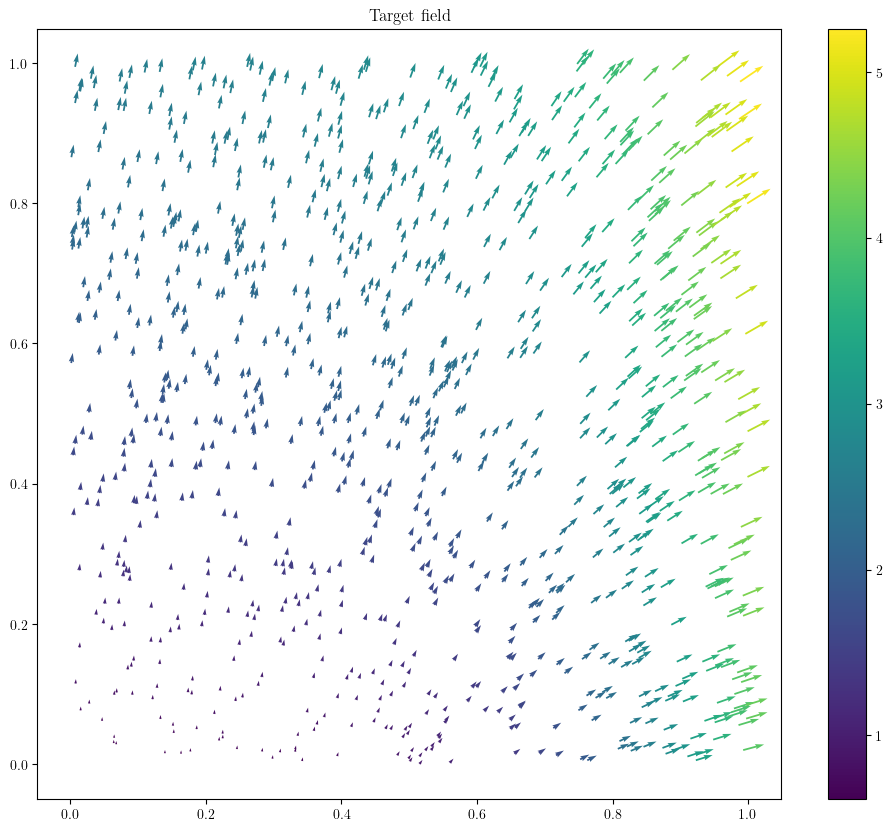

In [7]:
space = torch.rand(size=(1000,2))
fig,ax = plt.subplots(1,1,figsize=(12,10))

z = g(space)
p = ax.quiver(space[:,0],space[:,1], z[:,0],z[:,1],z.norm(dim=1), )
ax.set_title('Target field')
plt.colorbar(p)
plt.show()

In [52]:
input_dim = 2
output_dim = 2

model_CMGN = C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim)
model_ICGN = I_CGN(in_dim=input_dim,hidden=5,layers=0, ortho=0)

print("Number of parameters in C-MGN", sum(p.size().numel() for p in model_CMGN.parameters()))
print("Number of parameters in I-CGN", sum(p.size().numel() for p in model_ICGN.parameters()))

Number of parameters in C-MGN 14
Number of parameters in I-CGN 15


In [54]:
def train(model, lr, num_epochs, batch_size, dim=2):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    for i in range(num_epochs):
        input = torch.rand(size=(batch_size,dim))
        out = model(input)
        target = g(input)

        loss = (out - target).abs().sum() / batch_size

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if not i % 1000: print("Epoch", i, "Loss", loss.item())

In [55]:
lr = 1e-2
num_epochs = 10000
batch_size = 100
train(model_CMGN, lr, num_epochs, batch_size)

Epoch 0 Loss 1.5566924810409546
Epoch 1000 Loss 0.3582099974155426
Epoch 2000 Loss 0.39049747586250305
Epoch 3000 Loss 0.3670172095298767
Epoch 4000 Loss 0.38409289717674255
Epoch 5000 Loss 0.392630010843277
Epoch 6000 Loss 0.3558104634284973
Epoch 7000 Loss 0.41167572140693665
Epoch 8000 Loss 0.38163813948631287
Epoch 9000 Loss 0.38794124126434326


In [ ]:
train(model_ICGN, lr, num_epochs, batch_size)

Epoch 0 Loss 2.968963623046875
Epoch 1000 Loss 0.5460007786750793
Epoch 2000 Loss 0.22542685270309448
Epoch 3000 Loss 0.2225683182477951
Epoch 4000 Loss 0.21249116957187653
Epoch 5000 Loss 0.16990648210048676
Epoch 6000 Loss 0.18475943803787231
Epoch 7000 Loss 0.1666974276304245
Epoch 8000 Loss 0.22632232308387756
Epoch 9000 Loss 0.26291361451148987


This plots the norm of the error on the plane, sampled from a uniform set of points

C:\Users\mouad\AppData\Local\Temp\ipykernel_23656\2724137966.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z1 = (targ - out_CMGN).norm(dim=1).reshape(Xi.shape).T # .norm computes here the l2 error


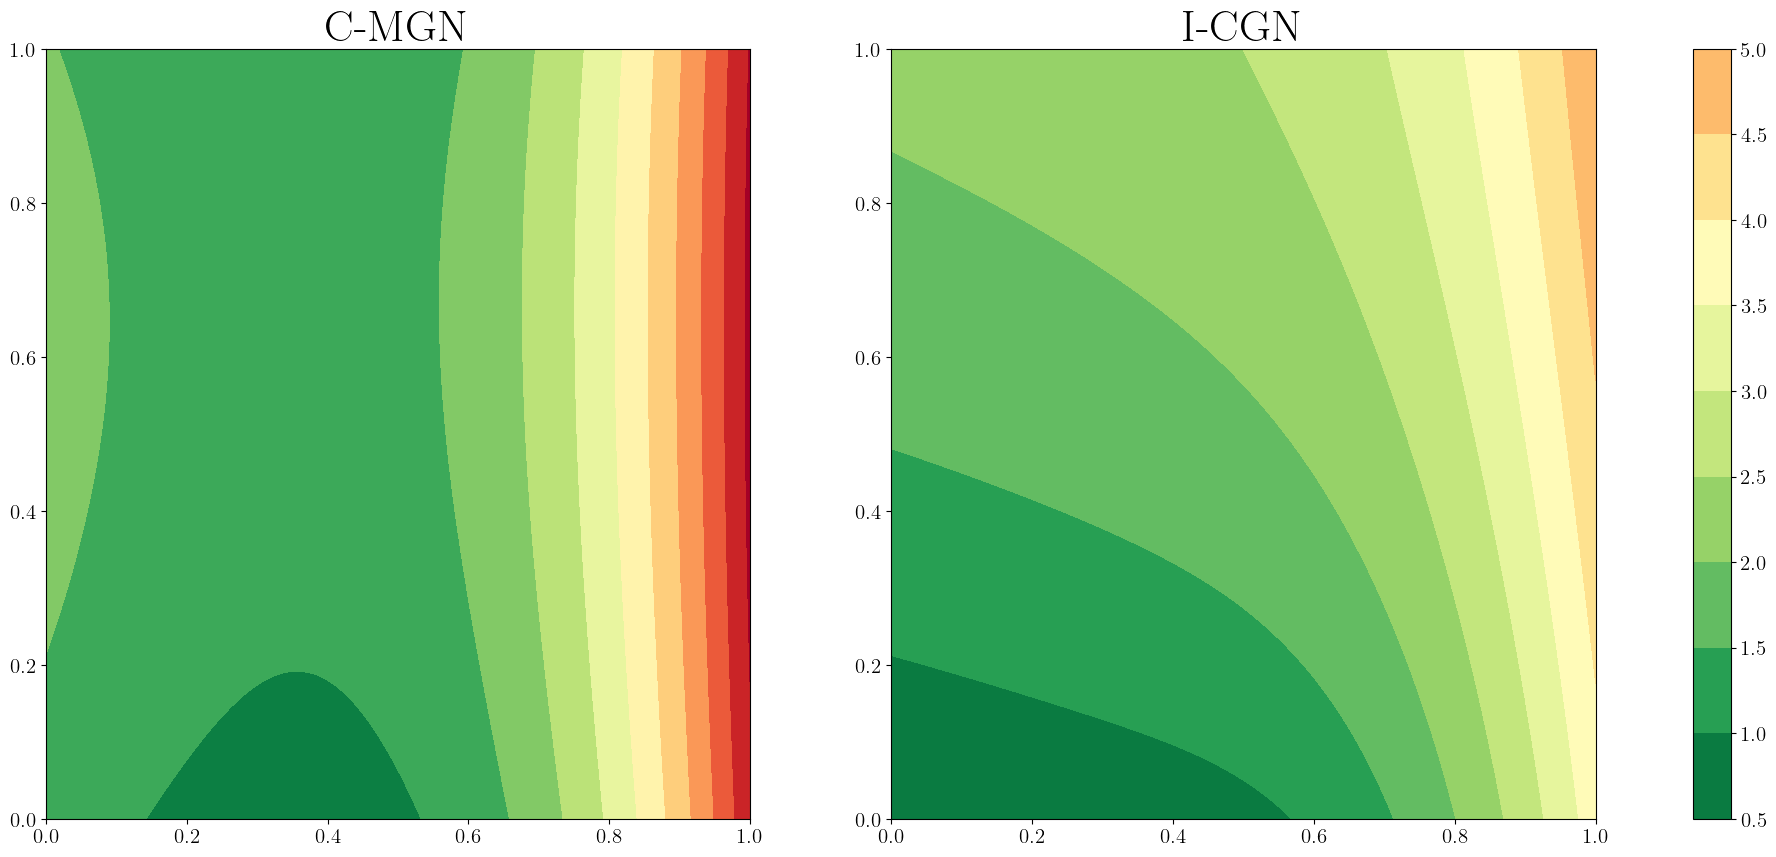

In [51]:
plt.rcParams['figure.figsize'] = (10,10)
fig,ax = plt.subplots(1,2,figsize=(25,10))

xi = torch.linspace(0, 1, 100)
yi = torch.linspace(0, 1, 100)



Xi, Yi = torch.meshgrid(xi, yi)
space = torch.cat([torch.reshape(Xi,(-1,1)),torch.reshape(Yi,(-1,1))],1)
targ = g(space)

out_CMGN = model_CMGN(space).detach().numpy()
z1 = (targ - out_CMGN).norm(dim=1).reshape(Xi.shape).T # .norm computes here the l2 error
out_ICGN = model_ICGN(space).detach()
z2 = (targ - out_ICGN).norm(dim=1).reshape(Xi.shape).T

cmax = max(z1.max(),z2.max())

#CMGN & ICGN PLOT
#ax[0].contour(xi, yi, z1, levels=8, linewidths=0.5, colors='w')
cmgn_plt = ax[0].contourf(xi, yi, z1, levels=10, cmap="magma",vmax=cmax)
icgn_plt = ax[1].contourf(xi, yi, z2, levels=10, cmap="magma",vmax=cmax)

ax[0].set_title('C-MGN',fontsize=32)
ax[1].set_title('I-CGN',fontsize=32)

ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)
#plt.tight_layout()
cbar = plt.colorbar(icgn_plt,ax=ax)
cbar.ax.tick_params(labelsize=15) 

# 2-Optimal Coupling

We generate two Gaussian distributions:

Source: A non-centered normal with covariance.
Target: A standard Gaussian.

In [8]:
# Set random seed
torch.manual_seed(42)

# we start by generating samples from a N(0, 1) and then apply the transformation Ax + µ to get the desired source distribution (using Cholesky decomposition)
mean_source = torch.tensor([2.0, 1.0])
cov_source = torch.tensor([[1.0, -0.8], [-0.8, 1.0]])

L = torch.linalg.cholesky(cov_source)
source_samples = torch.randn(1000, 2) @ L.T + mean_source
target_samples = torch.randn(1000, 2)

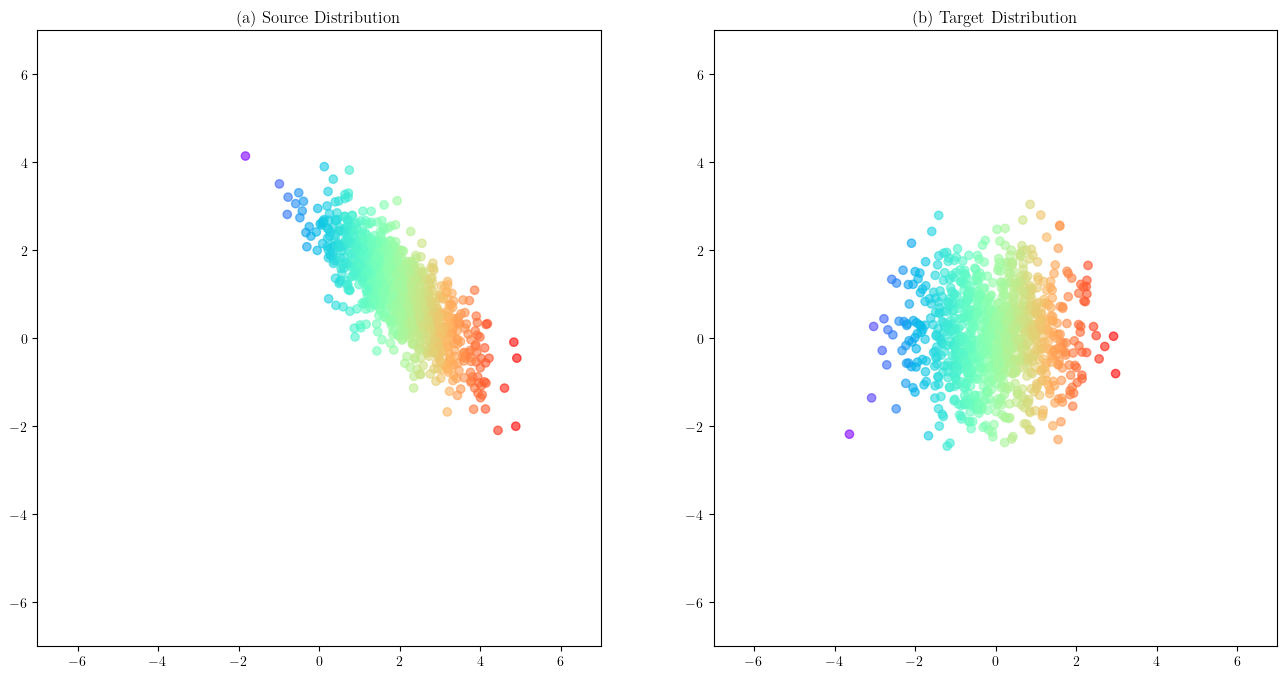

In [38]:
# Visualize both distributions
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.scatter(source_samples[:,0], source_samples[:,1], c=source_samples[:,0], cmap="rainbow", alpha=0.6)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("(a) Source Distribution")

plt.subplot(1,2,2)
plt.scatter(target_samples[:,0], target_samples[:,1], c=target_samples[:,0], cmap="rainbow", alpha=0.6)
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title("(b) Target Distribution")

plt.show()

In [40]:
import torch.distributions as dist

def kl_divergence_loss(model, source_samples):
    """
    returns back the Kullback-Leibler divergence and also the transformed samples returned by the model
    """
    transformed_samples = model(source_samples) # source one are N(µ, A.T@A)
    p_target = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))  # Standard normal
    q_transformed = dist.MultivariateNormal(transformed_samples.mean(dim=0), torch.cov(transformed_samples.T))
    
    return torch.distributions.kl_divergence(p_target, q_transformed).mean(), transformed_samples


In [41]:
def generate_source_data(mean_source, cov_source, num_samples):
    L = torch.linalg.cholesky(cov_source)
    target_samples = torch.randn(num_samples, 2)
    source_samples = target_samples @ L.T + mean_source
    return source_samples


In [42]:
def wasserstein_distance(source, target):
    mu_s, mu_t = source.mean(dim=0), target.mean(dim=0)
    sigma_s, sigma_t = torch.cov(source.T), torch.cov(target.T)
    cost = torch.norm(mu_s - mu_t) ** 2 + torch.trace(sigma_s + sigma_t - 2 * (sigma_s @ sigma_t).sqrt())
    return cost.item()

In [43]:
def plot_transport_evolution(model, num_samples_to_plot=1000):
    model.eval()
    source_samples = generate_source_data(mean_source, cov_source, num_samples=num_samples_to_plot)
    # target_samples_evol = torch.randn(num_samples_to_plot, 2) # N(0, 1)
    transformed_samples_evol = model(source_samples)
    return transformed_samples_evol

In [44]:
def train_optimal_coupling(model, epochs, lr, batch_size, plot_interval, input_dim, output_dim, optimizer, plot=False):
    costs_theorical = []
    transformed_samples_history = {}
    stored_costs = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        # we sample batch from the source distribution (N(µ, A.T@A))
        idx = torch.randint(0, source_samples.shape[0], (batch_size,))
        x_batch = source_samples[idx]

        # Compute KL loss
        loss, transformed_samples = kl_divergence_loss(model, x_batch)
        cost_theory = wasserstein_distance(transformed_samples, target_samples)
        costs_theorical.append(cost_theory)
        # distance btw two samples : sqrt(sum(xi - f(xi)^2)) (here only two dimensions (the sum))
        # we do the average across all the points of the current batch
        cost = torch.mean(torch.sqrt(torch.sum((transformed_samples - x_batch) ** 2, axis=1)))
        

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, KL Loss: {loss.item():.4f}")
            transformed_samples_evol = plot_transport_evolution(model, num_samples_to_plot=1000)
            transformed_samples_history[epoch] = transformed_samples_evol.detach().cpu().numpy() 
            stored_costs.append(cost.item())

        if epoch % plot_interval == 0 and plot==True:   
            plt.figure(figsize=(16,8)) 
            plt.subplot(1,2,1)
            plt.scatter(transformed_samples_evol[:,0].detach(), transformed_samples_evol[:,1].detach(), 
                        c=transformed_samples_evol[:,0].detach(), cmap="rainbow", alpha=0.6, label=f"Epoch {epoch}")
            plt.xlim(-7, 7)
            plt.ylim(-7, 7)
            plt.title(f"Transformed Samples Over Time : cost {cost}")
            plt.legend(loc="upper right", fontsize=8)  # Keep track of epochs

            plt.subplot(1,2,2)
            plt.scatter(target_samples[:,0], target_samples[:,1], 
                    c=target_samples[:,0], cmap="rainbow", alpha=0.6, label="Target Distribution")
            plt.xlim(-7, 7)
            plt.ylim(-7, 7)
            plt.title("Target Distribution")
            plt.legend(loc="upper right", fontsize=8)
            plt.show()
    return costs_theorical, stored_costs, transformed_samples_history

In [45]:
# Training settings
epochs = 1000
lr = 1e-2
batch_size = 100
plot_interval = 100
input_dim = 2
output_dim = 2

model_CMGN = C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim)
optimizer = torch.optim.Adam(model_CMGN.parameters(), lr=lr)

costs_theorical, stored_costs, transformed_samples_history = train_optimal_coupling(model_CMGN, 
                                                                                    epochs, 
                                                                                    lr, 
                                                                                    batch_size, 
                                                                                    plot_interval, 
                                                                                    input_dim, 
                                                                                    output_dim, 
                                                                                    optimizer,
                                                                                    plot=False)

Epoch 0, KL Loss: 59.5196
Epoch 100, KL Loss: 4.4008
Epoch 200, KL Loss: 4.0436
Epoch 300, KL Loss: 2.7974
Epoch 400, KL Loss: 2.2458
Epoch 500, KL Loss: 1.6923
Epoch 600, KL Loss: 0.9453
Epoch 700, KL Loss: 0.5204
Epoch 800, KL Loss: 0.2526
Epoch 900, KL Loss: 0.0607


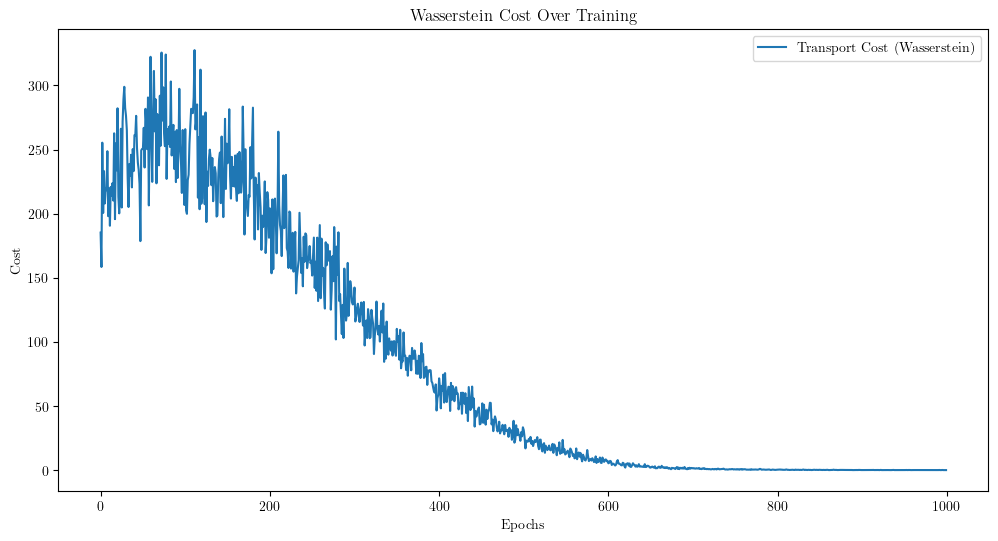

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(costs_theorical)), costs_theorical, label="Transport Cost (Wasserstein)")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.title("Wasserstein Cost Over Training")
plt.legend()
plt.show()

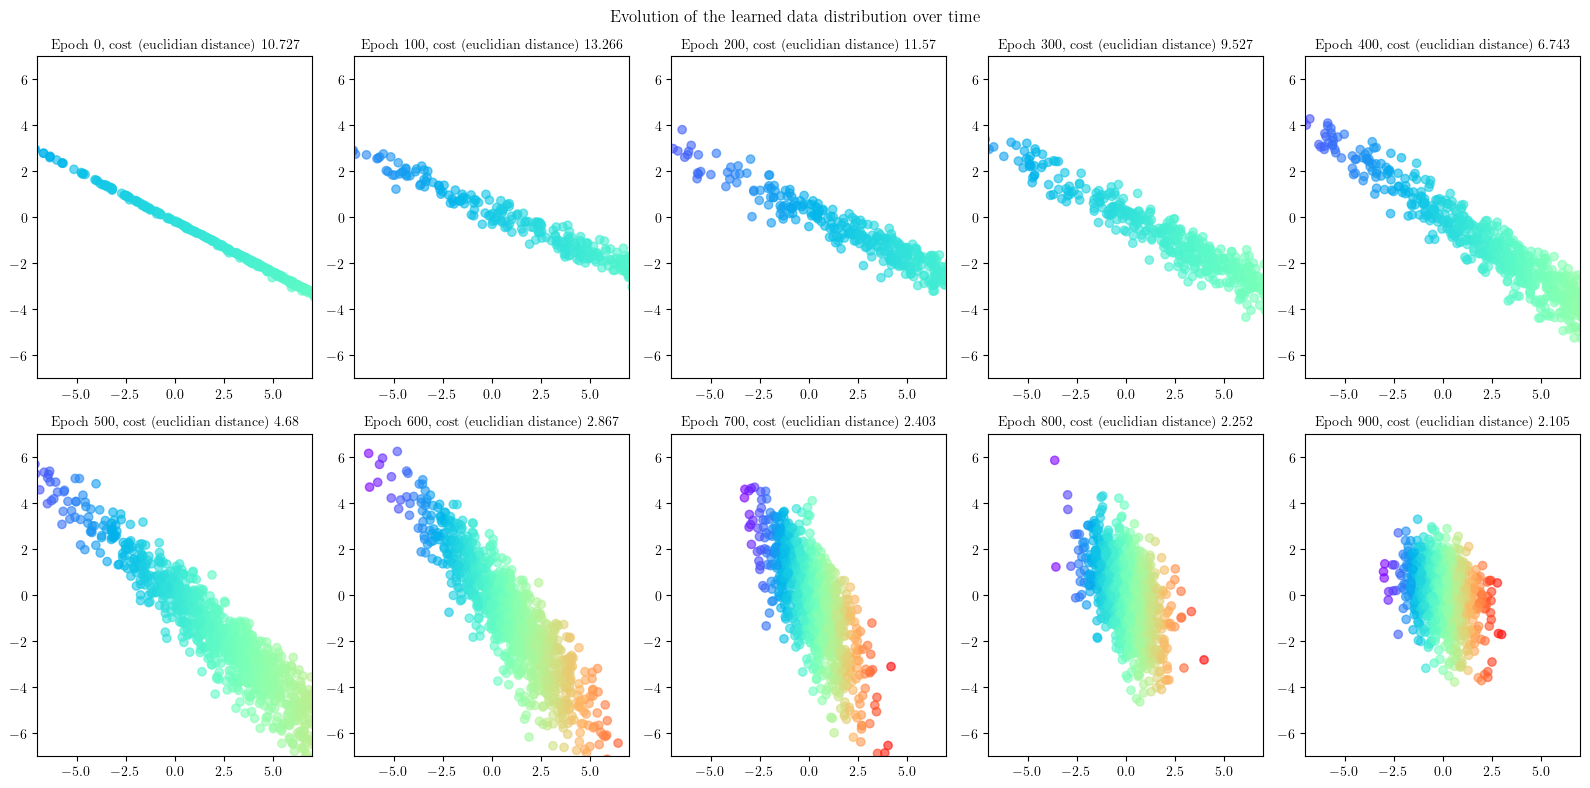

In [47]:
# Plot transformed samples at different epochs in a grid layout
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (epoch, transformed_samples) in enumerate(transformed_samples_history.items()):
    row = i // 5 
    col = i % 5

    ax = axes[row, col]
    ax.scatter(transformed_samples[:, 0], transformed_samples[:, 1], 
               c=transformed_samples[:, 0], cmap="rainbow", alpha=0.6)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_title(f"Epoch {epoch}, cost (euclidian distance) {np.round(stored_costs[i], 3)}", fontsize=10)

plt.suptitle("Evolution of the learned data distribution over time")
plt.tight_layout()
plt.show()


In [48]:
# for the ICGN 
# Training settings
epochs = 1000
lr = 1e-2
batch_size = 100
plot_interval = 100
input_dim = 2
output_dim = 2

model_ICGN = I_CGN(in_dim=input_dim,hidden=5,layers=0, ortho=0)
optimizer = torch.optim.Adam(model_ICGN.parameters(), lr=lr)

costs_theorical, stored_costs, transformed_samples_history = train_optimal_coupling(model_ICGN, 
                                                                                    epochs, 
                                                                                    lr, 
                                                                                    batch_size, 
                                                                                    plot_interval, 
                                                                                    input_dim, 
                                                                                    output_dim, 
                                                                                    optimizer,
                                                                                    plot=False)

Epoch 0, KL Loss: 2032.3379
Epoch 100, KL Loss: 228.7410
Epoch 200, KL Loss: 109.2946
Epoch 300, KL Loss: 73.1449
Epoch 400, KL Loss: 56.6859
Epoch 500, KL Loss: 45.8562
Epoch 600, KL Loss: 46.8735
Epoch 700, KL Loss: 32.2103
Epoch 800, KL Loss: 32.2429
Epoch 900, KL Loss: 35.9692


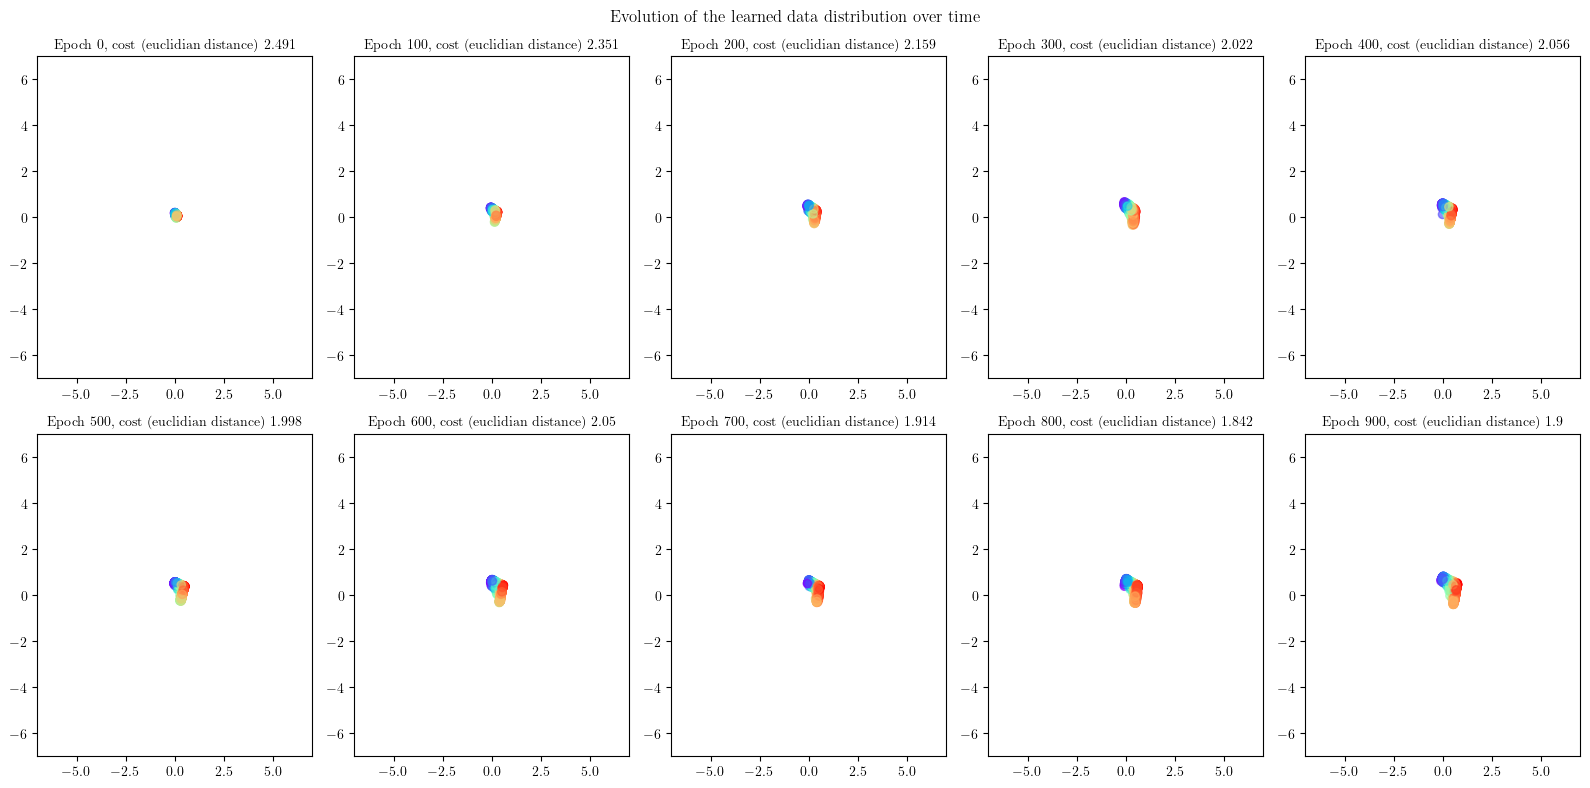

In [49]:
# Plot transformed samples at different epochs in a grid layout
fig, axes = plt.subplots(2, 5, figsize=(16, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, (epoch, transformed_samples) in enumerate(transformed_samples_history.items()):
    row = i // 5 
    col = i % 5

    ax = axes[row, col]
    ax.scatter(transformed_samples[:, 0], transformed_samples[:, 1], 
               c=transformed_samples[:, 0], cmap="rainbow", alpha=0.6)
    ax.set_xlim(-7, 7)
    ax.set_ylim(-7, 7)
    ax.set_title(f"Epoch {epoch}, cost (euclidian distance) {np.round(stored_costs[i], 3)}", fontsize=10)

plt.suptitle("Evolution of the learned data distribution over time")
plt.tight_layout()
plt.show()